# Attention Basics
In this notebook, we look at how attention is implemented. We will focus on implementing attention in isolation from a larger model. That's because when implementing attention in a real-world model, a lot of the focus goes into piping the data and juggling the various vectors rather than the concepts of attention themselves.

We will implement attention scoring as well as calculating an attention context vector.

## Attention Scoring
### Inputs to the scoring function
Let's start by looking at the inputs we'll give to the scoring function. We will assume we're in the first step in the decoding phase. The first input to the scoring function is the hidden state of decoder (assuming a toy RNN with three hidden nodes -- not usable in real life, but easier to illustrate):

In [1]:
dec_hidden_state = [5,1,20]

Let's visualize this vector:

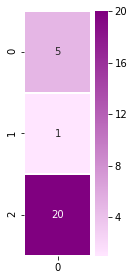

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Let's visualize our decoder hidden state
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(dec_hidden_state)), annot=True, cmap=sns.light_palette("purple", as_cmap=True), linewidths=1)

Our first scoring function will score a single annotation (encoder hidden state), which looks like this:

In [3]:
annotation = [3,12,45] #e.g. Encoder hidden state

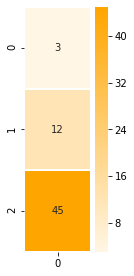

In [4]:
# Let's visualize the single annotation
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(annotation)), annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

### IMPLEMENT: Scoring a Single Annotation
Let's calculate the dot product of a single annotation. Numpy's [dot()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) is a good candidate for this operation

In [5]:
def single_dot_attention_score(dec_hidden_state, enc_hidden_state):
    # TODO: return the dot product of the two vectors
    return np.array(dec_hidden_state).dot(np.array(enc_hidden_state))
    
single_dot_attention_score(dec_hidden_state, annotation)

927


### Annotations Matrix
Let's now look at scoring all the annotations at once. To do that, here's our annotation matrix:

In [8]:
annotations = np.transpose([[3,12,45], [59,2,5], [1,43,5], [4,3,45.3]])
annotations

array([[ 3. , 59. ,  1. ,  4. ],
       [12. ,  2. , 43. ,  3. ],
       [45. ,  5. ,  5. , 45.3]])

And it can be visualized like this (each column is a hidden state of an encoder time step):

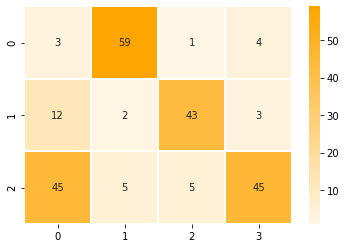

In [7]:
# Let's visualize our annotation (each column is an annotation)
ax = sns.heatmap(annotations, annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

### IMPLEMENT: Scoring All Annotations at Once
Let's calculate the scores of all the annotations in one step using matrix multiplication. Let's continue to us the dot scoring method

<img src="images/scoring_functions.png" />

To do that, we'll have to transpose `dec_hidden_state` and [matrix multiply](https://docs.scipy.org/doc/numpy/reference/generated/numpy.matmul.html) it with `annotations`.

In [9]:
def dot_attention_score(dec_hidden_state, annotations):
    # TODO: return the product of dec_hidden_state transpose and enc_hidden_states
    return np.array(dec_hidden_state).dot(annotations)
    
attention_weights_raw = dot_attention_score(dec_hidden_state, annotations)
attention_weights_raw

array([927., 397., 148., 929.])

Looking at these scores, can you guess which of the four vectors will get the most attention from the decoder at this time step?

## Softmax
Now that we have our scores, let's apply softmax:
<img src="images/softmax.png" />

In [10]:
def softmax(x):
    x = np.array(x, dtype=np.float128)
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=0) 

attention_weights = softmax(attention_weights_raw)
attention_weights

array([1.19202922e-001, 7.94715151e-232, 5.76614420e-340, 8.80797078e-001],
      dtype=float128)

Even when knowing which annotation will get the most focus, it's interesting to see how drastic softmax makes the end score become. The first and last annotation had the respective scores of 927 and 929. But after softmax, the attention they'll get is 0.12 and 0.88 respectively.

# Applying the scores back on the annotations
Now that we have our scores, let's multiply each annotation by its score to proceed closer to the attention context vector. This is the multiplication part of this formula (we'll tackle the summation part in the latter cells)

<img src="images/Context_vector.png" />

In [16]:
def apply_attention_scores(attention_weights, annotations): ### It is a matrix
    # TODO: Multiple the annotations by their weights
    return attention_weights*annotations

applied_attention = apply_attention_scores(attention_weights, annotations)
applied_attention

array([[3.57608766e-001, 4.68881939e-230, 5.76614420e-340,
        3.52318831e+000],
       [1.43043506e+000, 1.58943030e-231, 2.47944200e-338,
        2.64239123e+000],
       [5.36413149e+000, 3.97357575e-231, 2.88307210e-339,
        3.99001076e+001]], dtype=float128)

Let's visualize how the context vector looks now that we've applied the attention scores back on it:

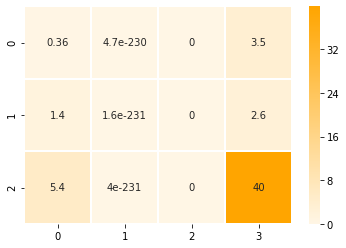

In [17]:
# Let's visualize our annotations after applying attention to them
ax = sns.heatmap(applied_attention, annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

Contrast this with the raw annotations visualized earlier in the notebook, and we can see that the second and third annotations (columns) have been nearly wiped out. The first annotation maintains some of its value, and the fourth annotation is the most pronounced.

# Calculating the Attention Context Vector
All that remains to produce our attention context vector now is to sum up the four columns to produce a single attention context vector


In [18]:
def calculate_attention_vector(applied_attention):
    return np.sum(applied_attention, axis=1)

attention_vector = calculate_attention_vector(applied_attention)
attention_vector

array([ 3.88079708,  4.0728263 , 45.26423912], dtype=float128)

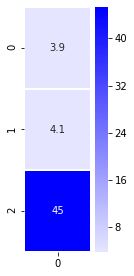

In [19]:
# Let's visualize the attention context vector
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(attention_vector)), annot=True, cmap=sns.light_palette("Blue", as_cmap=True), linewidths=1)

Now that we have the context vector, we can concatenate it with the hidden state and pass it through a hidden layer to produce the the result of this decoding time step.